In [94]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

In [95]:
# problem domain
def y(x,E,w,I,a):
    return w*x**2*(a-x)**2/(24*E*I)
#Parameters
E=127e9
t=0.000935
b=50e-3
I=b*t**3/12
a=0.027487
L=a
x_theoretical = np.linspace(0, L, 100)
rng = np.random.default_rng(seed=42)
x=rng.uniform(0, L, 1000)
x_theoretical = x
q_load=860210.526316
y_theoretical = y(x_theoretical,E,q_load,I,L)
n_collocation = 1000  # puntos en dominio
n_bnd = 2  # puntos en frontera (x=0, x=L)
seed = 1234
q=q_load


In [96]:
E=1
I=1
L=1
q=1


In [ ]:
# NN architecture / training
hidden_layers = [50, 50, 50, 50]
activation = nn.Tanh  # en el paper usan swish/tanh


In [98]:
# ====== MLP builder ======
def build_mlp(input_dim, output_dim, hidden_layers, act=nn.Tanh):
    layers = []
    prev = input_dim
    for h in hidden_layers:
        layers.append(nn.Linear(prev, h))
        layers.append(act())
        prev = h
    layers.append(nn.Linear(prev, output_dim))
    return nn.Sequential(*layers)

# ====== redes separadas para w, theta, M, Q ======
w_net = build_mlp(1, 1, hidden_layers, act=activation)
theta_net = build_mlp(1, 1, hidden_layers, act=activation)
M_net = build_mlp(1, 1, hidden_layers, act=activation)
Q_net = build_mlp(1, 1, hidden_layers, act=activation)

nets = [w_net, theta_net, M_net, Q_net]

In [99]:
lr = 1e-3
n_epochs = 5000
use_lbfgs = False
torch.manual_seed(seed)
np.random.seed(seed)

In [100]:
# ====== derivative function ======
def deriv(y, x, order=1):
    # y: tensor scalar output; x: tensor inputs (requires_grad=True)
    assert x.requires_grad, "x must require_grad"
    out = y
    for i in range(order):
        grads = autograd.grad(outputs=out, inputs=x,
                              grad_outputs=torch.ones_like(out),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
        out = grads
    return out


In [101]:
# ====== collocation points ======
rng = np.random.default_rng(seed=42)
x_coll_np = rng.uniform(0, L, 1000).reshape(-1, 1).astype(np.float32)
x_coll = torch.tensor(x_coll_np, requires_grad=True)
#Boundary points
x_b0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
x_bL = torch.tensor([[L]], dtype=torch.float32, requires_grad=True)



In [102]:
def pinn_loss(nets, x_in, x_b0, x_bL):
    w_pred = nets[0](x_in)          # w(x)
    theta_pred = nets[1](x_in)      # theta(x)
    M_pred = nets[2](x_in)          # M(x)
    Q_pred = nets[3](x_in)          # Q(x)

    dw_dx = deriv(w_pred, x_in, order=1)
    Lw = dw_dx - theta_pred #First equation

    dtheta_dx = deriv(theta_pred, x_in, order=1)
    Ltheta = dtheta_dx + M_pred / (E * I) #Second equation
    
    # dM/dx + Q = 0  => L_M
    dM_dx = deriv(M_pred, x_in, order=1)
    LM = dM_dx + Q_pred

    # dQ/dx + q(x) = 0 (but in paper they might include terms b,k etc)
    dQ_dx = deriv(Q_pred, x_in, order=1)
    q_vals = q*torch.ones_like(x_in)  # assuming constant load q
    LQ = dQ_dx + q_vals  # + other terms if model includes k,w,b

    # PDE residual norms (MSE)
    loss_w = torch.mean(Lw**2)
    loss_theta = torch.mean(Ltheta**2)
    loss_M = torch.mean(LM**2)
    loss_Q = torch.mean(LQ**2)
    # Boundary conditions w(0)=0, w(L)=0, theta(0)=0, theta(L)=0
    w_b0_pred = nets[0](x_b0)
    w_bL_pred = nets[0](x_bL)
    theta_b0_pred = nets[1](x_b0)
    theta_bL_pred = nets[1](x_bL)

    loss_bcs= torch.mean(w_b0_pred**2) + torch.mean(w_bL_pred**2) + \
                torch.mean(theta_b0_pred**2) + torch.mean(theta_bL_pred**2)
    total = loss_w + loss_theta + loss_M + loss_Q + loss_bcs
    return total, dict(loss_w=loss_w.item(), loss_theta=loss_theta.item(),
                       loss_M=loss_M.item(), loss_Q=loss_Q.item(), loss_bcs=loss_bcs.item())


In [103]:
# ====== optimizer ======
params = []
for net in nets:
    params += list(net.parameters())

optimizer = torch.optim.Adam(params, lr=lr)

# Optional L-BFGS closure
if use_lbfgs:
    lbfgs_optimizer = torch.optim.LBFGS(params, max_iter=500, tolerance_grad=1e-9, tolerance_change=1e-12, history_size=50)

# ====== TRAINING LOOP ======
loss_history = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    total_loss, comp = pinn_loss(nets, x_coll, x_b0, x_bL)
    total_loss.backward()
    optimizer.step()

    loss_history.append(total_loss.item())

    if epoch % 500 == 0 or epoch == 1:
        print(f"Epoch {epoch:6d} | Loss {total_loss.item():.3e} | components: {comp}")

    # optionally run L-BFGS every few thousand epochs or at the end
    if use_lbfgs and epoch % 5000 == 0:
        def closure():
            lbfgs_optimizer.zero_grad()
            loss_lb, _ = pinn_loss(nets, x_coll, x_b0, x_bL)
            loss_lb.backward()
            return loss_lb
        print("  --> Running L-BFGS refinement ...")
        lbfgs_optimizer.step(closure)




Epoch      1 | Loss 9.901e-01 | components: {'loss_w': 1.266496747120982e-05, 'loss_theta': 0.003002895973622799, 'loss_M': 0.01692398078739643, 'loss_Q': 0.9574683308601379, 'loss_bcs': 0.01272592693567276}
Epoch    500 | Loss 1.395e-04 | components: {'loss_w': 1.2545185199996922e-05, 'loss_theta': 3.7522579532378586e-06, 'loss_M': 7.274529343703762e-05, 'loss_Q': 4.420537152327597e-05, 'loss_bcs': 6.293957085290458e-06}
Epoch   1000 | Loss 1.145e-04 | components: {'loss_w': 1.7628479326958768e-05, 'loss_theta': 7.1875815592648e-06, 'loss_M': 6.220093200681731e-05, 'loss_Q': 2.1297275452525355e-05, 'loss_bcs': 6.174711415951606e-06}
Epoch   1500 | Loss 4.451e-05 | components: {'loss_w': 1.0889628356380854e-05, 'loss_theta': 5.622092430712655e-06, 'loss_M': 9.193446203425992e-06, 'loss_Q': 9.463550668442622e-06, 'loss_bcs': 9.342322300653905e-06}
Epoch   2000 | Loss 1.766e-05 | components: {'loss_w': 7.286807431228226e-06, 'loss_theta': 4.633104708773317e-06, 'loss_M': 4.76117719472313

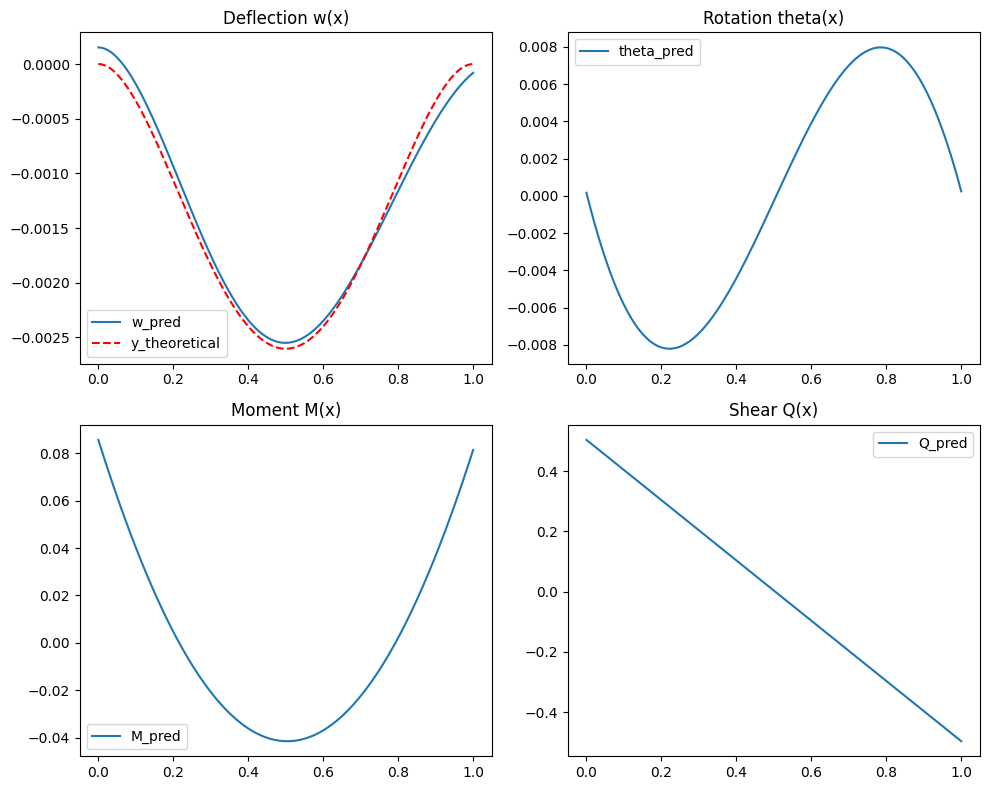

In [104]:
# ====== Results: evaluate on dense grid and plot ======
x_plot = torch.tensor(np.linspace(0, L, 200).reshape(-1,1).astype(np.float32), requires_grad=True)
with torch.no_grad():
    w_pred_plot = w_net(x_plot).cpu().numpy().flatten()
    theta_pred_plot = theta_net(x_plot).cpu().numpy().flatten()
    M_pred_plot = M_net(x_plot).cpu().numpy().flatten()
    Q_pred_plot = Q_net(x_plot).cpu().numpy().flatten()
x_np = x_plot.cpu().detach().numpy()

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(x_np, w_pred_plot, label='w_pred')
plt.plot(x_np, y(x_np,E,-q,I,L), 'r--', label='y_theoretical')
plt.title('Deflection w(x)')
plt.legend()
plt.subplot(2,2,2)
plt.plot(x_np, theta_pred_plot, label='theta_pred')
plt.title('Rotation theta(x)')
plt.legend()
plt.subplot(2,2,3)
plt.plot(x_np, M_pred_plot, label='M_pred')
plt.title('Moment M(x)')
plt.legend()
plt.subplot(2,2,4)
plt.plot(x_np, Q_pred_plot, label='Q_pred')
plt.title('Shear Q(x)')
plt.legend()
plt.tight_layout()
plt.show()